Group members:
- Aya Abdelgawad
- Eric Ge 
- Jay Acosta
- Vandana George

# The Problem
We will attempt to use classification algorithms to predict the presence of malicious code in a program. Having a relatively accurate classifier would be a great asset for antiviral protection, allowing users to protect their computers. In addition, this analysis in general would be fruitful for finding trends in compromised data and finding the most effective features to search for in order to classify code as suspicious.

The dataset we will be using was supplied by Max Secure Partner for a malware detection competition. It includes metadata on thousands of Portable Executable (PE) files, a common executable format on Windows machines. The first half of the features collected come from the fields of the PE header (see [the documentation](https://docs.microsoft.com/en-us/windows/win32/debug/pe-format) for more details), and the latter half come from analysis that Max Secure Partner collected while the program was running. The final field labels the program as either legitimate or not (containing malicious code). Some examples of the metrics included are the length of the header, the flags for the file, its hash, and the min/max/average entropy of the resources it uses while running.

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline

### Data Cleaning
In this section, we read in and the data and make sure it's all properly formatted.

In [2]:
# read in data using low_memory=False so it can properly read in the md5 hashes as strings
data = pd.read_csv('Kaggle-data.csv', low_memory=False)

# display description of all columns
pd.set_option('display.max_columns', None)
data.describe(include='all')

,ID,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMinEntropy,SectionsMaxEntropy,SectionsMeanRawsize,SectionsMinRawsize,SectionMaxRawsize,SectionsMeanVirtualsize,SectionsMinVirtualsize,SectionMaxVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate,Unnamed: 57
count,216352.000000,216352,216352,216352.000000,216352.000000,216351.000000,216352.000000,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,216352.000000,216352.000000,216352.000000,216352.000000,216352.000000,216352.000000,216352.000000,2.163520e+05,2.163520e+05,2.163520e+05,216352.000000,216352.000000,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,216352.000000,216352.000000,216352.000000,216352.000000,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,216352.000000,216352.000000,216352.000000,216352.000000,216352.000000,216352.000000,216352.000000,216352.000000,2.163520e+05,2.163520e+05,2.163520e+05,2.163520e+05,216352.000000,216352.000000,1.0
unique,NaN,209329,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,9873531e6ba01adecf7e1e0f68c2df1a,332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,25,197618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,108176.500000,NaN,NaN,225.390197,4658.018849,9.052688,4.297964,3.953857e+05,5.827978e+05,1.332425e+06,2.812198e+05,9.263616e+04,2.597506e+05,6.825622e+14,8.973149e+03,876.249815,5.891214,1.908686,65.019649,62.194170,4.915735,1.062089,8.306375e+05,1.444321e+03,1.198387e+08,2.211697,19125.945395,8.226597e+07,8.135296e+07,1.375880e+06,4.596753e+04,9.237207e+04,6.160888e+04,4.907304,4.500140,2.046629,6.780452,1.623791e+05,1.908853e+04,5.588631e+05,1.824943e+05,2.066624e+04,6.279258e+05,7.375374,114.004788,4.702134,24.093205,21.311201,3.758643,2.391066,5.149387,9.997022e+04,7.139624e+04,2.524535e+05,1.023401e+06,7.888492,0.348982,0.0
std,62455.587057,NaN,NaN,4.559983,7843.855241,71.522478,11.965284,1.962775e+07,2.841106e+07,7.337809e+07,1.254327e+07,9.922827e+06,6.712844e+06,1.121701e+17,7.194441e+05,1362.854293,183.580174,227.045651,1163.764427,1153.224766,1.041145,144.727471,6.859762e+06,5.878291e+03,4.965103e+08,0.500514,16258.493510,3.782155e+10,3.782156e+10,1.478766e+08,7.974684e+06,1.370714e+07,1.242031e+07,2.554187,1.121715,1.825340,1.049097,6.451482e+06,3.186122e+05,2.573865e+07,3.393885e+06,3.189600e+05,1.073093e+07,727.966935,137.024438,36.612958,267.169003,130.677090,1.305126,1.042133,1.864471,1.718201e+07,1.681531e+07,2.433613e+07,4.772522e+07,8.049384,0.476649,NaN
min,1.000000,NaN,NaN,176.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.553600e+04,0.000000e+00,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

Looking at the description of our dataframe, we immediately see two columns that have nothing to do with the data and can be dropped: 'ID' (which is jus the row id) and 'Unnamed: 57' (which was likely created due to an error while reading in the csv data). Let's go ahead and get rid of those features.

In [3]:
data = data.drop(columns=['ID', 'Unnamed: 57'])

Next, let's check the dataframe for NaNs. Notice from the output below there is only 1 record that contains any NaNs (and only for 1 feature). Since we have hundreds of thousands of records, it will not hurt us to just remove that 1 record.

In [4]:
# print out any features that have non-0 NaNs
col_nans = data.isna().sum()
for i in range(len(col_nans)):
    if col_nans[i] > 0:
        print(f"{data.columns[i]} has {col_nans[i]} NaNs")

# drop the row with the NaN
print("# of rows before dropping: " + str(data.shape[0]))
data = data.dropna()
print("# of rows after dropping: " + str(data.shape[0]))

MajorLinkerVersion has 1 NaNs
# of rows before dropping: 216352
# of rows after dropping: 216351


Many of our attributes are represented numerically, but some of them really make more sense as categorical variables. The featuers 'Characteristics', 'DllCharacteristics', and 'LoaderFlags' are all actually flags and map to about 16 binary flag features each. We will handle that mapping problem later on in the feature engineering section by implementing a custom one-hot-encoding method. Here, we will properly format the 'Machine' and 'Subsystem' features, which are codes that map to a particular CPU and subsystem needed to support the PE, respectively.

We'll start by cleaning the 'Machine' feature. Since there are many possible machine codes and only 8 present in our dataset, let's first review the values we have so we only need to map those values.

In [5]:
# print all unique values for machine code
print(data['Machine'].unique())

# there's one strange machine code value...is it legitimate?
strange_machine_code = data[data['Machine'] == '3ab1aa9785d0681434766bb0ffc4a13c']['legitimate']
print(strange_machine_code)

['332' '34404' '450' '422' '512' '43620'
 '3ab1aa9785d0681434766bb0ffc4a13c' '452']
41963    0
Name: legitimate, dtype: int64


The above output contains all valid possible values except for the strange hex one. As suspected, it belongs to an illegitimate executable. We will keep this in mind when mapping the values and be sure to label unexpected/invalid values as errors.

In [6]:
# Mapping values in Machine to their meaning - Machine will now be categorical
machine_keys = {
  "332": "IMAGE_FILE_MACHINE_I386",
  "422": "IMAGE_FILE_MACHINE_SH4",
  "450": "IMAGE_FILE_MACHINE_THUMB",
  "452": "IMAGE_FILE_MACHINE_ARMNT",
  "512": "IMAGE_FILE_MACHINE_IA64",
  "34404": "IMAGE_FILE_MACHINE_AMD64",
  "43620": "IMAGE_FILE_MACHINE_ARM64"
}
data['Machine'] = data['Machine'].map(machine_keys).fillna("IMAGE_FILE_MACHINE_ERROR")
print("Unique values for Machine feature are now:")
print(data['Machine'].unique())

# Mapping values in Subsystem to their meaning - Subsystem will now be categorical
subsystem_keys = {
  0: "IMAGE_SUBSYSTEM_UNKNOWN",
  1: "IMAGE_SUBSYSTEM_NATIVE",
  2: "IMAGE_SUBSYSTEM_WINDOWS_GUI",
  3: "IMAGE_SUBSYSTEM_WINDOWS_CUI",
  5: "IMAGE_SUBSYSTEM_OS2_CUI",
  7: "IMAGE_SUBSYSTEM_POSIX_CUI",
  9: "IMAGE_SUBSYSTEM_WINDOWS_CE_GUI",
  10: "IMAGE_SUBSYSTEM_EFI_APPLICATION",
  11: "IMAGE_SUBSYSTEM_EFI_BOOT_SERVICE_DRIVER",
  12: "IMAGE_SUBSYSTEM_EFI_RUNTIME_DRIVER",
  13: "IMAGE_SUBSYSTEM_EFI_ROM",
  14: "IMAGE_SUBSYSTEM_XBOX",
  16: "IMAGE_SUBSYSTEM_WINDOWS_BOOT_APPLICATION"
}
data['Subsystem'] = data['Subsystem'].map(subsystem_keys).fillna("IMAGE_SUBSYSTEM_ERROR")
print("Unique values for Subsystem feature are now:")
print(data['Subsystem'].unique())

Unique values for Machine feature are now:
['IMAGE_FILE_MACHINE_I386' 'IMAGE_FILE_MACHINE_AMD64'
 'IMAGE_FILE_MACHINE_THUMB' 'IMAGE_FILE_MACHINE_SH4'
 'IMAGE_FILE_MACHINE_IA64' 'IMAGE_FILE_MACHINE_ARM64'
 'IMAGE_FILE_MACHINE_ERROR' 'IMAGE_FILE_MACHINE_ARMNT']
Unique values for Subsystem feature are now:
['IMAGE_SUBSYSTEM_WINDOWS_GUI' 'IMAGE_SUBSYSTEM_WINDOWS_CE_GUI'
 'IMAGE_SUBSYSTEM_WINDOWS_CUI' 'IMAGE_SUBSYSTEM_NATIVE'
 'IMAGE_SUBSYSTEM_WINDOWS_BOOT_APPLICATION' 'IMAGE_SUBSYSTEM_UNKNOWN']


### Data Exploration
Time to create some visualizations to get a better understanding of our data!

Let's start by getting an overview of how our variables are correlated. This will give us an idea of which variables are giving us similar information. Below, we see a correlation matrix of all our variables, with darker backgrounds representing higher correlations. 

In [7]:
# display color-coordinated correlation matrix
data.corr().style.background_gradient()

,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMinEntropy,SectionsMaxEntropy,SectionsMeanRawsize,SectionsMinRawsize,SectionMaxRawsize,SectionsMeanVirtualsize,SectionsMinVirtualsize,SectionMaxVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
SizeOfOptionalHeader,1.000000,0.071615,0.053298,-0.076454,0.070781,0.049606,-0.005530,0.004054,-0.002660,-0.011760,0.019496,-0.000996,-0.071197,0.000378,-0.001037,0.047413,0.045562,0.251709,0.000389,0.004230,-0.003871,-0.073063,-0.183426,0.006884,0.006888,0.006748,-0.001592,-0.002054,-0.001512,0.035673,-0.117299,-0.020237,-0.237927,0.001834,0.037031,0.001257,0.002144,0.035523,0.001468,0.050790,0.089659,0.061549,0.043154,0.042438,-0.012347,0.098977,-0.079851,-0.001586,-0.001286,-0.002461,-0.006537,0.226898,0.384716
Characteristics,0.071615,1.000000,-0.018760,0.350582,0.006158,0.000895,-0.006256,0.012908,0.024252,0.040869,-0.003584,-0.002533,-0.031585,0.000219,0.003649,0.018844,0.020239,-0.016919,0.000367,0.004624,0.004464,0.069708,-0.448730,-0.001269,-0.001263,-0.000489,0.013563,0.018273,0.001105,0.110902,-0.404926,-0.274831,-0.217150,0.006719,0.016332,0.007749,0.005352,0.017705,0.001200,0.000340,0.028534,-0.002077,0.030855,0.087461,-0.045767,-0.013748,-0.077281,-0.002910,-0.002365,-0.003526,-0.005389,0.020373,0.227615
MajorLinkerVersion,0.053298,-0.018760,1.000000,-0.018499,0.003884,0.002607,0.000574,-0.000356,0.002233,-0.000905,0.000166,0.012665,-0.001507,0.009608,0.004600,0.001575,0.001578,0.014387,-0.000040,-0.000286,0.289633,-0.001763,0.015580,-0.000032,-0.000032,-0.000067,-0.000170,0.000772,-0.000235,0.001602,0.014408,0.011275,-0.014804,-0.000280,0.000592,-0.000313,-0.000139,0.000462,-0.000244,0.996602,-0.005466,0.020855,-0.000439,-0.002058,0.234257,0.018066,-0.004062,-0.000013,0.000007,-0.000062,0.001329,-0.004347,0.009264
MinorLinkerVersion,-0.076454,0.350582,-0.018499,1.000000,0.049021,0.021032,0.024871,0.008945,0.027716,0.007506,0.000355,-0.002380,-0.045773,0.032757,0.056264,0.000674,0.001899,-0.142270,0.003746,0.000884,-0.001141,0.017566,-0.146422,-0.000769,-0.000773,-0.000853,0.002604,0.020263,0.006169,0.179522,-0.243994,-0.268962,-0.025004,-0.003158,-0.015828,-0.001415,-0.000176,-0.013972,-0.000612,0.000874,0.011616,-0.030335,-0.012139,0.011389,-0.037926,-0.076229,-0.028160,-0.001468,-0.001460,-0.000527,-0.000989,-0.190958,-0.123139
SizeOfCode,0.070781,0.006158,0.003884,0.049021,1.000000,0.320853,0.134945,0.001284,0.218070,0.196505,0.000070,0.000008,0.011037,-0.000083,-0.000114,0.029767,0.044001,-0.002515,-0.000090,0.005357,0.002000,0.001406,-0.007083,-0.000010,0.000013,0.008537,0.099918,0.094460,0.000028,0.003439,0.000994,-0.000633,-0.000903,0.000786,-0.000637,0.000848,0.001999,-0.000431,0.002349,0.000049,0.010195,0.007294,0.006128,0.004996,-0.005364,-0.004693,-0.003430,0.000245,0.000268,0.000164,-0.000263,-0.006280,-0.002950
SizeOfInitializedData,0.049606,0.000895,0.002607,0.021032,0.320853,1.000000,0.097395,0.001307,0.171767,0.153370,0.000034,-0.000085,0.001639,-0.000120,-0.000117,0.024663,0.045910,-0.005799,-0.000073,0.092431,0.000068,-0.001047,-0.008680,-0.000026,0.000005,0.006261,0.124824,0.089695,0.000006,-0.001066,0.007074,0.005983,0.003550,0.002330,0.010334,0.002098,0.051361,0.010526,0.058406,-0.000040,0.003124,0.002964,0.001146,0.010827,-0.002641,-0.007036,0.001968,-0.000007,-0.000060,0.0

Here are some highlights we found from the expansive output:
- The feature with the highest correlation to legitimacy was 'MajorSubsystemVersion', indicating that this is likely an important feature to keep for our analysis. Intuitively, this makes sense because we expect that older systems are more vulnerable to malware. 
- For the statistics measured, they come in 3's: mean, min, and max. As a general trend, there tended to be a high correlation between mean & min and mean & max. Intuitively, this makes sense because we expect the mean to summarize our entire data. We can utilize this by only using the mean feature in our training and not have to keep min or max.
- In the optional header, all of the entries have a fixed size, except the last one: 'NumberOfRvaAndSizes'. It tells us how many directory entries are in the header. 'SizeOfOptionalHeader' gives the total size of the header. Intuitively, these two variables are telling us very similar things (how big is the whole thing vs. how big is it beyond some fixed size). However, the correlation between 'NumberOfRvaAndSizes' and 'SizeOfOptionalHeader' is -0.001512! This contradiction to our expectation warrants some investigation. First, let's visualize the variables.

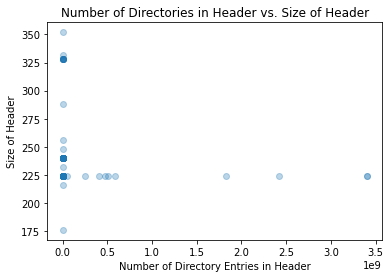

In [8]:
# Plot NumberOfRvaAndSizes vs. SizeOfOptionalHeader
plt.scatter(data['NumberOfRvaAndSizes'], data['SizeOfOptionalHeader'], alpha=0.3)
plt.xlabel('Number of Directory Entries in Header')
plt.ylabel('Size of Header')
plt.title('Number of Directories in Header vs. Size of Header')
plt.show()

We suspect that this odd behavior is caused by the malicious records. If we plot the same graph but only for legitimate and malicious records (as shown below), then we learn that all legitimate records have 16 directory entries and header sizes of 224-240 bytes (since directories are variable-sized, this variation is not surprising or alarming). The graph of malicious executables strongly resembles the one where we included all our dataset, indicating that the odd behavior originates from our malicious records. This trend is still helpful to keep in mind, as it indicates these features may be helpful for classification.

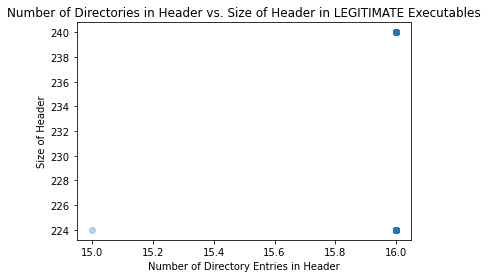

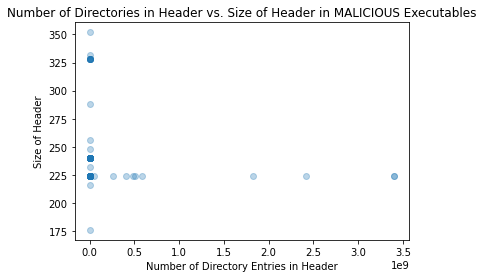

In [9]:
# plot for legitimate executables
legit = data[data['legitimate'] == 1]
plt.scatter(legit['NumberOfRvaAndSizes'], legit['SizeOfOptionalHeader'], alpha=0.3)
plt.xlabel('Number of Directory Entries in Header')
plt.ylabel('Size of Header')
plt.title('Number of Directories in Header vs. Size of Header in LEGITIMATE Executables')
plt.show()

# plot for malicious executables
not_legit = data[data['legitimate'] == 0]
plt.scatter(not_legit['NumberOfRvaAndSizes'], not_legit['SizeOfOptionalHeader'], alpha=0.3)
plt.xlabel('Number of Directory Entries in Header')
plt.ylabel('Size of Header')
plt.title('Number of Directories in Header vs. Size of Header in MALICIOUS Executables')
plt.show()

As mentioned earlier, we believe older systems should be more vulnerable to malware. This seems to be the case for MajorSubsystemVersion, based on the correlation noted earlier and by the boxplot below. 

<AxesSubplot:title={'center':'MajorSubsystemVersion'}, xlabel='[legitimate]'>

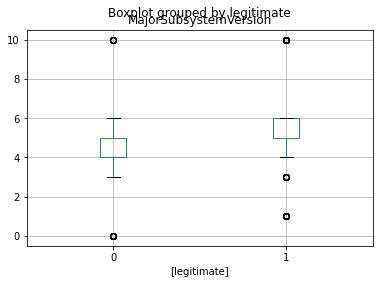

In [10]:
# sanity check: intuition says older subsys more vulnerable to malware
# let's see if this is true for our data
data.boxplot(column=['MajorSubsystemVersion'], by=['legitimate'])
# yeah most of data on lower end

We want to check if this trend also appears with the operating system version. However, when we make a boxplot, there are some strange outliers in the malicious records (unsurprisingly), so let's filter out the invalid values (the max valid value is 10). After filtering out invalid values, we see that malicious records do tend to belong to older systems.

<AxesSubplot:title={'center':'MajorOperatingSystemVersion'}, xlabel='[legitimate]'>

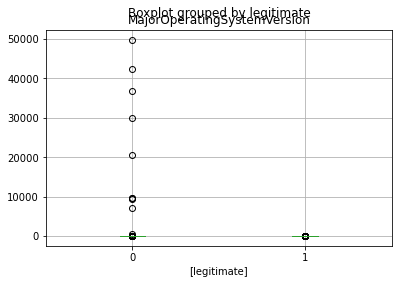

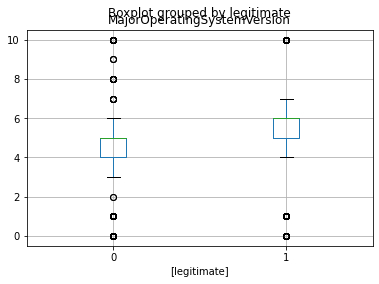

In [11]:

data.boxplot(column=['MajorOperatingSystemVersion'], by=['legitimate'])
# have some weird outliers in non-legit data, 
# so let's look at only valid values (10 or less)
noout = data[data['MajorOperatingSystemVersion'] < 11]
noout.boxplot(column=['MajorOperatingSystemVersion'], by=['legitimate'])
# yeah most of data on lower end

Let's also confirm that this trend applies with the linker version as well. Surprisingly, this doesn't seem to apply for the linker version, indicating we may not want to use it. Note we still see the greater variation among malicious record that we have come to expect.

<AxesSubplot:title={'center':'MajorLinkerVersion'}, xlabel='[legitimate]'>

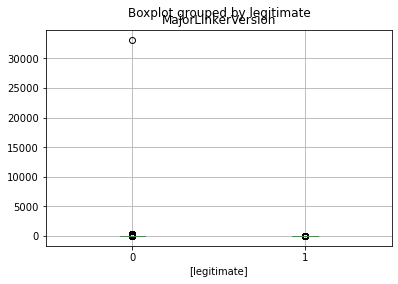

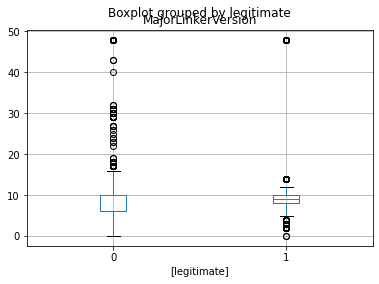

In [12]:
# sanity check: intuition says older linker more vulnerable to malware
# let's see if this is true for our data
data.boxplot(column=['MajorLinkerVersion'], by=['legitimate'])
# have some weird outliers in non-legit data -> remove
noout = data[data['MajorLinkerVersion'] < 50]
noout.boxplot(column=['MajorLinkerVersion'], by=['legitimate'])
# not strictly align with intuition, but noticing that there is a lot of variation in non-legit

### Feature Selection & Engineering
In this section, we will choose which features to drop based on their relevance to the problem of trying to detect malware. Some of these features will also need to be engineered, such as binning for the versioning features and implementing a custom one-hot-encoding method for the flag features.

Because 'MajorSubsytemVersion' follows a nice clean trend and doesn't have major outliers, we think two simple bins will work fine to describe the linker version: 5 or less is "old", greater than that is "new". However, we know that 'MajorOperatingSystemVersion' has some extremely strange values and large fluctionations, so that one we will bin 5 or less as "old", 6-10 as "new", and >10 as "invalid" because those do not currently correspond to real OS versions.

In [13]:
# bin subsys version
data['SubsystemVersion'] = pd.cut(
    data['MajorSubsystemVersion'], 
    [0, 5, max(data['MajorSubsystemVersion'])],
    labels=['old', 'new'],
    include_lowest=True)

# bin OS version
data['OSVersion'] = pd.cut(
    data['MajorOperatingSystemVersion'], 
    [0, 5, 10, max(data['MajorOperatingSystemVersion'])],
    labels=['old', 'new', 'invalid'],
    include_lowest=True)

# make sure no NaNs introduced
print ("Number of NaNs in SubsystemVersion:", data['SubsystemVersion'].isna().sum ())
print ("Number of NaNs in OSVersion:", data['OSVersion'].isna().sum ())

Number of NaNs in SubsystemVersion: 0
Number of NaNs in OSVersion: 0


Although 'Characteristics', 'DllCharacteristics', and 'LoaderFlags' are all flag features, we will only be implementing the custom one-hot-encoding for 'DllCharacteristics' because we do not want to keep all of the new features that would be created by feature engineering all three. This would increase the number of dimensions we have beyond a reasonable point. We choose to keep 'DllCharacterists' rather than any of the other flag features because we are interested in having context about the linker (because there are attacks that exploit linkers), and 'MajorLinkerVersion' did not seem as useful to us.

In [14]:
dll_flag_offsets = {
    5: "IMAGE_DLL_CHARACTERISTICS_HIGH_ENTROPY_VA", 
    6: "IMAGE_DLLCHARACTERISTICS_DYNAMIC_BASE",
    7: "IMAGE_DLLCHARACTERISTICS_FORCE_INTEGRITY",
    8: "IMAGE_DLLCHARACTERISTICS_NX_COMPAT",
    9: "IMAGE_DLLCHARACTERISTICS_NO_ISOLATION",
    10: "IMAGE_DLLCHARACTERISTICS_NO_SEH",
    11: "IMAGE_DLLCHARACTERISTICS_NO_BIND",
    12: "IMAGE_DLL_CHARACTERISTICS_APPCONTAINER",
    13: "IMAGE_DLLCHARACTERISTICS_WDM_DRIVER",
    14: "IMAGE_DLL_CHARACTERISTICS_GUARD_CF",
    15: "IMAGE_DLLCHARACTERISTICS_TERMINAL_SERVER_AWARE"}

for flag_offset in dll_flag_offsets:
    data[dll_flag_offsets[flag_offset]] = data['DllCharacteristics'].apply(lambda f: f >> flag_offset & 1)

We also need to do the normal one-hot-encode for our categorical varaibles: 'Machine' and 'Subsystem'.

In [15]:
encoded_data = pd.get_dummies(data, columns=['Subsystem', 'Machine'], drop_first=True)

Based on our analysis and understanding of the features, we think the features below will not be as helpful for determining if code is malicious (or, in the case of 'md5', it was just too much of a hassle to try to create such a large dataframe with every hash one-hot-encoded).

In [16]:
# bin subsys version
data['SubsystemVersion'] = pd.cut(
    data['MajorSubsystemVersion'], 
    [0, 5, max(data['MajorSubsystemVersion'])],
    labels=['old', 'new'],
    include_lowest=True)

# bin OS version
data['OSVersion'] = pd.cut(
    data['MajorOperatingSystemVersion'], 
    [0, 5, 10, max(data['MajorOperatingSystemVersion'])],
    labels=['old', 'new', 'invalid'],
    include_lowest=True)

# make sure no NaNs introduced
print ("Number of NaNs in SubsystemVersion:", data['SubsystemVersion'].isna().sum ())
print ("Number of NaNs in OSVersion:", data['OSVersion'].isna().sum ())

data.head()

Features dropped: 29
Number of features in dataframe: 50


,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMinEntropy,SectionsMaxEntropy,SectionsMeanRawsize,SectionsMinRawsize,SectionMaxRawsize,SectionsMeanVirtualsize,SectionsMinVirtualsize,SectionMaxVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate,SubsystemVersion,OSVersion
0,b69acb3bb133974e48229627663f96d4,IMAGE_FILE_MACHINE_I386,224,8450,8.0,0,16896,8192,0,16947,4096,24576,4194304.0,4096,512,6,0,6,0,5,1,40960,1024,84427,IMAGE_SUBSYSTEM_WINDOWS_GUI,320,262144,4096,1048576,4096,0,16,4,3.761598,2.446533,6.450720,6016.000000,1024,16896,6096.250000,960.0,16731,3,44,0,31,1,3.492126,3.492126,3.492126,864.0,864.0,864,72,0,1,old,new
1,1cbee4b3725629bd0aa6ac2ff500925f,IMAGE_FILE_MACHINE_I386,224,258,9.0,0,84480,25600,0,10973,4096,90112,65536.0,4096,512,5,0,9,0,4,20,126976,1024,180181,IMAGE_SUBSYSTEM_WINDOWS_CE_GUI,320,65536,4096,1048576,4096,0,16,5,4.973822,3.269968,6.504334,22016.000000,1024,84480,21902.800000,992.0,84410,2,102,100,2,1,3.486827,3.486827,3.486827,892.0,892.0,892,72,0,1,old,old
2,b7027cf0cd31c820928950cbfe7e91ef,IMAGE_FILE_MACHINE_I386,224,8450,8.0,0,4608,3584,0,6452,4096,12288,264962048.0,4096,512,6,0,6,0,6,0,24576,1024,10208,IMAGE_SUBSYSTEM_WINDOWS_GUI,320,262144,4096,1048576,4096,0,16,4,3.329824,0.278747,6.051986,1792.000000,512,4608,1708.000000,414.0,4294,2,27,0,3,1,3.517270,3.517270,3.517270,952.0,952.0,952,72,0,1,new,new
3,156a0bb069f94d1e7c2508318805f2a4,IMAGE_FILE_MACHINE_I386,224,8450,10.0,0,108544,15872,0,105021,4096,114688,268435456.0,4096,512,6,1,8,0,6,1,143360,1024,165754,IMAGE_SUBSYSTEM_WINDOWS_CUI,320,1048576,4096,1048576,4096,0,16,5,3.404831,0.160329,6.662718,24883.200000,512,108544,25645.400000,85.0,108180,12,66,0,105,2,3.270559,3.034188,3.506931,1032.0,972.0,1092,72,0,1,new,new
4,c72bf851fed5542abba904b1f3944cd5,IMAGE_FILE_MACHINE_I386,224,8226,48.0,0,513024,2048,0,520922,8192,524288,268435456.0,8192,512,4,0,0,0,6,0,540672,512,582537,IMAGE_SUBSYSTEM_WINDOWS_CUI,34144,1048576,4096,1048576,4096,0,16,3,2.978056,0.101910,6.390683,171690.666667,512,513024,171265.333333,12.0,512736,1,1,0,0,1,3.420977,3.420977,3.420977,954.0,954.0,954,0,0,1,new,old


Although 'Characteristics', 'DllCharacteristics', and 'LoaderFlags' are all flag features, we will only be implementing the custom one-hot-encoding for 'DllCharacteristics' because we do not want to keep all of the new features that would be created by feature engineering all three. This would increase the number of dimensions we have beyond a reasonable point. We choose to keep 'DllCharacterists' rather than any of the other flag features because we are interested in having context about the linker (because there are attacks that exploit linkers), and 'MajorLinkerVersion' did not seem as useful to us.

In [14]:
dll_flag_offsets = {
    5: "IMAGE_DLL_CHARACTERISTICS_HIGH_ENTROPY_VA", 
    6: "IMAGE_DLLCHARACTERISTICS_DYNAMIC_BASE",
    7: "IMAGE_DLLCHARACTERISTICS_FORCE_INTEGRITY",
    8: "IMAGE_DLLCHARACTERISTICS_NX_COMPAT",
    9: "IMAGE_DLLCHARACTERISTICS_NO_ISOLATION",
    10: "IMAGE_DLLCHARACTERISTICS_NO_SEH",
    11: "IMAGE_DLLCHARACTERISTICS_NO_BIND",
    12: "IMAGE_DLL_CHARACTERISTICS_APPCONTAINER",
    13: "IMAGE_DLLCHARACTERISTICS_WDM_DRIVER",
    14: "IMAGE_DLL_CHARACTERISTICS_GUARD_CF",
    15: "IMAGE_DLLCHARACTERISTICS_TERMINAL_SERVER_AWARE"}

for flag_offset in dll_flag_offsets:
    data[dll_flag_offsets[flag_offset]] = data['DllCharacteristics'].apply(lambda f: f >> flag_offset & 1)

data.head()

,md5,Machine,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,MinorOperatingSystemVersion,MajorImageVersion,MinorImageVersion,MajorSubsystemVersion,MinorSubsystemVersion,SizeOfImage,SizeOfHeaders,CheckSum,Subsystem,DllCharacteristics,SizeOfStackReserve,SizeOfStackCommit,SizeOfHeapReserve,SizeOfHeapCommit,LoaderFlags,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMinEntropy,SectionsMaxEntropy,SectionsMeanRawsize,SectionsMinRawsize,SectionMaxRawsize,SectionsMeanVirtualsize,SectionsMinVirtualsize,SectionMaxVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate,SubsystemVersion,OSVersion,IMAGE_DLL_CHARACTERISTICS_HIGH_ENTROPY_VA,IMAGE_DLLCHARACTERISTICS_DYNAMIC_BASE,IMAGE_DLLCHARACTERISTICS_FORCE_INTEGRITY,IMAGE_DLLCHARACTERISTICS_NX_COMPAT,IMAGE_DLLCHARACTERISTICS_NO_ISOLATION,IMAGE_DLLCHARACTERISTICS_NO_SEH,IMAGE_DLLCHARACTERISTICS_NO_BIND,IMAGE_DLL_CHARACTERISTICS_APPCONTAINER,IMAGE_DLLCHARACTERISTICS_WDM_DRIVER,IMAGE_DLL_CHARACTERISTICS_GUARD_CF,IMAGE_DLLCHARACTERISTICS_TERMINAL_SERVER_AWARE
0,b69acb3bb133974e48229627663f96d4,IMAGE_FILE_MACHINE_I386,224,8450,8.0,0,16896,8192,0,16947,4096,24576,4194304.0,4096,512,6,0,6,0,5,1,40960,1024,84427,IMAGE_SUBSYSTEM_WINDOWS_GUI,320,262144,4096,1048576,4096,0,16,4,3.761598,2.446533,6.450720,6016.000000,1024,16896,6096.250000,960.0,16731,3,44,0,31,1,3.492126,3.492126,3.492126,864.0,864.0,864,72,0,1,old,new,0,1,0,1,0,0,0,0,0,0,0
1,1cbee4b3725629bd0aa6ac2ff500925f,IMAGE_FILE_MACHINE_I386,224,258,9.0,0,84480,25600,0,10973,4096,90112,65536.0,4096,512,5,0,9,0,4,20,126976,1024,180181,IMAGE_SUBSYSTEM_WINDOWS_CE_GUI,320,65536,4096,1048576,4096,0,16,5,4.973822,3.269968,6.504334,22016.000000,1024,84480,21902.800000,992.0,84410,2,102,100,2,1,3.486827,3.486827,3.486827,892.0,892.0,892,72,0,1,old,old,0,1,0,1,0,0,0,0,0,0,0
2,b7027cf0cd31c820928950cbfe7e91ef,IMAGE_FILE_MACHINE_I386,224,8450,8.0,0,4608,3584,0,6452,4096,12288,264962048.0,4096,512,6,0,6,0,6,0,24576,1024,10208,IMAGE_SUBSYSTEM_WINDOWS_GUI,320,262144,4096,1048576,4096,0,16,4,3.329824,0.278747,6.051986,1792.000000,512,4608,1708.000000,414.0,4294,2,27,0,3,1,3.517270,3.517270,3.517270,952.0,952.0,952,72,0,1,new,new,0,1,0,1,0,0,0,0,0,0,0
3,156a0bb069f94d1e7c2508318805f2a4,IMAGE_FILE_MACHINE_I386,224,8450,10.0,0,108544,15872,0,105021,4096,114688,268435456.0,4096,512,6,1,8,0,6,1,143360,1024,165754,IMAGE_SUBSYSTEM_WINDOWS_CUI,320,1048576,4096,1048576,4096,0,16,5,3.404831,0.160329,6.662718,24883.200000,512,108544,25645.400000,85.0,108180,12,66,0,105,2,3.270559,3.034188,3.506931,1032.0,972.0,1092,72,0,1,new,new,0,1,0,1,0,0,0,0,0,0,0
4,c72bf851fed5542abba904b1f3944cd5,IMAGE_FILE_MACHINE_I386,224,8226,48.0,0,513024,2048,0,520922,8192,524288,268435456.0,8192,512,4,0,0,0,6,0,540672,512,582537,IMAGE_SUBSYSTEM_WINDOWS_CUI,34144,1048576,4096,1048576,4096,0,16,3,2.978056,0.101910,6.390683,171690.666667,512,513024,171265.333333,12.0,512736,1,1,0,0,1,3.420977,3.420977,3.420977,954.0,954.0,954,0,0,1,new,old,1,1,0,1,0,1,0,0,0,0,1


We also need to do the normal one-hot-encode for our categorical varaibles: 'Machine' and 'Subsystem'.

In [15]:
data = pd.get_dummies(data, columns=['Subsystem', 'Machine'], drop_first=True)

Based on our analysis and understanding of the features, we think the features below will not be as helpful for determining if code is malicious (or, in the case of 'md5', it was just too much of a hassle to try to create such a large dataframe with every hash one-hot-encoded).

In [16]:
# will get rid of the following for preliminary cleaning:
clean_out = ['md5', 'Characteristics', 'MajorLinkerVersion', 'MinorLinkerVersion', 'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion', 'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorImageVersion', 'MajorSubsystemVersion', 'MinorSubsystemVersion', 'CheckSum', 'DllCharacteristics', 'SizeOfStackReserve', 'SizeOfStackCommit', 'SizeOfHeapReserve', 'SizeOfHeapCommit', 'LoaderFlags', 'SectionsMinEntropy', 'SectionsMaxEntropy', 'SectionsMinRawsize', 'SectionMaxRawsize', 'SectionsMinVirtualsize', 'SectionMaxVirtualsize', 'ResourcesMinEntropy', 'ResourcesMaxEntropy', 'ResourcesMinSize', 'ResourcesMaxSize']

# print out the number of features dropped
print("Features dropped:", len(clean_out))

data = data.drop(columns=clean_out)

# how many features do we have now?
print("Number of features in dataframe:", data.shape[1])

# check head to make sure features are as expect
data.head()


Features dropped: 29
Number of features in dataframe: 50


,SizeOfOptionalHeader,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SizeOfImage,SizeOfHeaders,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMeanRawsize,SectionsMeanVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMeanSize,LoadConfigurationSize,VersionInformationSize,legitimate,SubsystemVersion,OSVersion,IMAGE_DLL_CHARACTERISTICS_HIGH_ENTROPY_VA,IMAGE_DLLCHARACTERISTICS_DYNAMIC_BASE,IMAGE_DLLCHARACTERISTICS_FORCE_INTEGRITY,IMAGE_DLLCHARACTERISTICS_NX_COMPAT,IMAGE_DLLCHARACTERISTICS_NO_ISOLATION,IMAGE_DLLCHARACTERISTICS_NO_SEH,IMAGE_DLLCHARACTERISTICS_NO_BIND,IMAGE_DLL_CHARACTERISTICS_APPCONTAINER,IMAGE_DLLCHARACTERISTICS_WDM_DRIVER,IMAGE_DLL_CHARACTERISTICS_GUARD_CF,IMAGE_DLLCHARACTERISTICS_TERMINAL_SERVER_AWARE,Subsystem_IMAGE_SUBSYSTEM_UNKNOWN,Subsystem_IMAGE_SUBSYSTEM_WINDOWS_BOOT_APPLICATION,Subsystem_IMAGE_SUBSYSTEM_WINDOWS_CE_GUI,Subsystem_IMAGE_SUBSYSTEM_WINDOWS_CUI,Subsystem_IMAGE_SUBSYSTEM_WINDOWS_GUI,Machine_IMAGE_FILE_MACHINE_ARM64,Machine_IMAGE_FILE_MACHINE_ARMNT,Machine_IMAGE_FILE_MACHINE_ERROR,Machine_IMAGE_FILE_MACHINE_I386,Machine_IMAGE_FILE_MACHINE_IA64,Machine_IMAGE_FILE_MACHINE_SH4,Machine_IMAGE_FILE_MACHINE_THUMB
0,224,16896,8192,0,16947,4096,24576,4194304.0,40960,1024,16,4,3.761598,6016.000000,6096.250000,3,44,0,31,1,3.492126,864.0,72,0,1,old,new,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,224,84480,25600,0,10973,4096,90112,65536.0,126976,1024,16,5,4.973822,22016.000000,21902.800000,2,102,100,2,1,3.486827,892.0,72,0,1,old,old,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,224,4608,3584,0,6452,4096,12288,264962048.0,24576,1024,16,4,3.329824,1792.000000,1708.000000,2,27,0,3,1,3.517270,952.0,72,0,1,new,new,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
3,224,108544,15872,0,105021,4096,114688,268435456.0,143360,1024,16,5,3.404831,24883.200000,25645.400000,12,66,0,105,2,3.270559,1032.0,72,0,1,new,new,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,224,513024,2048,0,520922,8192,524288,268435456.0,540672,512,16,3,2.978056,171690.666667,171265.333333,1,1,0,0,1,3.420977,954.0,0,0,1,new,old,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0


### Training
Now that we've selected and engineered our features, we can try out different classification algorithms. The specific classifiers we will be trying are
- Decision Trees (with and without md5 hashes)
- Naive Bayes (with and without md5 hashes)
- K-Nearest Neighbors
- Neural Networks
- Random Forest
- SVM

#### Decision Trees (with and without md5 hashes)
Aya put stuff here

#### Naive Bayes (with and without md5 hashes)
Jay put stuff here

#### K-Nearest Neighbors
Eric put stuff here (don't forget to normalize data first)

#### Neural Networks
Eric put stuff here (dont forget to normalize)

#### Random Forest
Vandana put stuff here

In [17]:
# Imports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import pickle
import warnings
import time
warnings.simplefilter("ignore")

In [18]:
# To do: Delete later
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import make_scorer, confusion_matrix

# from homework
def print_confusion_matrix(TN, FP, FN, TP):
    table_data = [[TP,FN],[FP,TN]]
    df = pd.DataFrame(table_data, columns =['Predicted Safe','Predicted Unsafe'])
    df = df.rename(index={0: 'Actual Safe', 1: 'Actual Unsafe'})
    display(df)

# written by Jay
def split_feats_labels (data, class_label='legitimate'):
    return data.drop (columns=[class_label]), data[class_label]

"""
Cost Matrix: 
    pass in costs based on penalty for 
    these evaluations [TP, FP, FN, TN]

    when doing greater_is_better, sklearn chooses to have + as a penalty, and - as a reward
    reward correct classifications
    lighter penalty for marking malicious but actually safe
    harsher penalty for marking safe but actually malicious
"""
def get_scorer (cost_matrix=[-10, 100, 50, -10]):
    
    def calc_cost (y_true, y_pred, **kwargs):
        return (cost_matrix * confusion_matrix(y_true, y_pred).ravel()).sum ()
    
    return make_scorer (calc_cost, greater_is_better=False)

score = get_scorer ()

We will build a Random Forest Classifier (RFC).
RFC will randomly select a subset of the input features
instead of examining all available features.

---

We will start by separating the data into data_Y (class label column)
and data_X (columns of all other features).
Our total data of 216351 data points: 140849 not legititmate, 75502 legitimate.
We want to deal with class imbalances in our data so we will
will use an equal number of 'legitimate' and 'not legitimate' records.
We will use Undersampling to get 75502 legitimate and 
75502 not legitimate data points. This is a total of 151,004 data points.

In [49]:
num_legit = (data['legitimate'] == 1).sum()
num_malicious = (data['legitimate'] == 0).sum()

deep_copy_data = data.copy()
random_pruned_data = deep_copy_data.groupby("legitimate").sample(n=num_legit, random_state=2)

num_legit = (random_pruned_data['legitimate'] == 1).sum()
num_malicious = (random_pruned_data['legitimate'] == 0).sum()
print ("Percent Malicious:", num_malicious / len (random_pruned_data))
print ("Percent Safe:", num_legit / len (random_pruned_data))

random_pruned_data = pd.get_dummies(random_pruned_data, columns=['SubsystemVersion','OSVersion'], drop_first=True)

Percent Malicious: 0.5
Percent Safe: 0.5


In [54]:
# Get 151,004 data points with balanced classes 
features = random_pruned_data.copy()
labels = features.pop('legitimate')
print(features.shape)
print(labels.shape)
print(labels.value_counts())
#print(features.head())

(151004, 50)
(151004,)
0    75502
1    75502
Name: legitimate, dtype: int64


We will use 5-fold GridSearchCV to find the best of these parameters:

Random Forests can take a long time to train, so we wanted to use a limited number of
parameters, mostly focusing on the size of the tree, the number of the trees. 
We will use criterion = Gini, because Entropy has higher computational 
cost due to the log in the equation.

Our starting parameters are:
number of trees = 100, criterion = gini, max_depth = [10,20,30]

In [55]:
def make_RFC(features, labels, param_grid,score):
    # Create RFC object
    rfc = RandomForestClassifier()
    
    start = time.time()
    print("start")
    grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring=score)
    grid_search.fit(features,labels)
    print(grid_search.best_params_)
    print(grid_search.best_score_)
    return grid_search

We created the RFC Model. The best parameters are: {'criterion': 'gini', 'max_depth': 30, 'n_estimators': 100}
We will use a 5 fold Cross Validation to predict and evaluate our model.

In [56]:
param_grid = {
        'n_estimators': [100],
        'criterion':['gini'],
        'max_depth': [10,20,30],
}

# Create RFC Model
rfc_model_1 = make_RFC(features,labels, param_grid,score)
# Save model
#filename = 'rfc_model_1.sav'
#pickle.dump(rfc_model_1, open(filename, 'wb'))

start
{'criterion': 'gini', 'max_depth': 30, 'n_estimators': 100}
266116.0


In [57]:
pred = cross_val_predict(rfc_model_1, features, labels, cv=5)
print ("Average accuracy:", accuracy_score (labels, pred))
print_confusion_matrix (*confusion_matrix (labels, pred).ravel ())
print ("Classification Report:")
print (classification_report (labels, pred))

Average accuracy: 0.9864440677068157


,Predicted Safe,Predicted Unsafe
Actual Safe,74631,871
Actual Unsafe,1176,74326


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     75502
           1       0.98      0.99      0.99     75502

    accuracy                           0.99    151004
   macro avg       0.99      0.99      0.99    151004
weighted avg       0.99      0.99      0.99    151004



The Accuracy is very high, so we decided to test this on the entire dataset,
because we think there might be some overfitting.

In [58]:
data_copy = data.dropna(axis=0, inplace=False).copy()
data_copy = pd.get_dummies(data_copy, columns=['SubsystemVersion', 'OSVersion'], drop_first=True)
all_X = pd.DataFrame(data_copy.copy())
all_Y = pd.DataFrame(all_X.pop('legitimate'))

loaded_model = rfc_model_1

start = time.time()
result = loaded_model.predict(all_X)
end = time.time()
print("time to predict: ", end-start)
pred = pd.DataFrame(result)
pred.rename(columns = {0:'prediction'}, inplace = True)
# Print results
print("RFC Model 1 predicting entire dataset")
print_confusion_matrix (*confusion_matrix (all_Y, pred).ravel ())
print ("Classification Report:")
print (classification_report (all_Y, pred))

time to predict:  2.241138219833374
RFC Model 1 predicting entire dataset


,Predicted Safe,Predicted Unsafe
Actual Safe,75478,24
Actual Unsafe,973,139876


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    140849
           1       0.99      1.00      0.99     75502

    accuracy                           1.00    216351
   macro avg       0.99      1.00      0.99    216351
weighted avg       1.00      1.00      1.00    216351



The Accuracy and Recall is high (99%-100%). The high Accuracy and Recall rates is suspicious, so we believe we are overfitting for the dataset given. If we had more time, we would reduce the max depth of the tree to test out max_depth = [10,15,20]. If we didn't have long runtimes to consider, we would also try to increase min_samples_leaf to [11,21,31,41,51] (Odd numbers in case of majority voting) and min_impurity_decrease to 0.1.

##### Mitigating Class Imbalance

Our dataset has a slight class imbalance. To mitigate this, we will choose to undersample our dataset and run our models against this undersampled data.

In [17]:
deep_copy_data = data.copy()
random_pruned_data = deep_copy_data.groupby("legitimate").sample(n=num_legit, random_state=2)
labels = random_pruned_data["legitimate"]
features = random_pruned_data.drop(columns = ["legitimate", 'OSVersion'])

num_legit = (random_pruned_data['legitimate'] == 1).sum()
num_malicious = (random_pruned_data['legitimate'] == 0).sum()

print ("Percent Malicious:", num_malicious / len (random_pruned_data))
print ("Percent Safe:", num_legit / len (random_pruned_data))
random_pruned_data.head ()

NameError: name 'num_legit' is not defined

##### Helper Methods

Next, we will define to some utility methods for evaluating our models. The `print_confusion_matrix` method will display a stylized table of a proximity matrix. `split_feats_labels` will split data into labels and features.  Lastly, the `get_scorer` method allows us to apply a cost matrix to a confusion matrix and get the cost of a model.


Additionally, we have also included the helper method `get_k_feat_names`, which returns the names of features from a `SelectKBest` object, which is sklearn's method of picking the best _K_ features to run on a dataset.

In [22]:
# from homework
def print_confusion_matrix(TN, FP, FN, TP):
    table_data = [[TP,FN],[FP,TN]]
    df = pd.DataFrame(table_data, columns =['Predicted Safe','Predicted Unsafe'])
    df = df.rename(index={0: 'Actual Safe', 1: 'Actual Unsafe'})
    display(df)

# written by Jay
def split_feats_labels (data, class_label='legitimate'):
    return data.drop (columns=[class_label]), data[class_label]

def get_k_feat_names (KBest, data):
    cols = KBest.get_support(indices=True)
    return [name for name in data.iloc[:,cols]]

from sklearn.metrics import make_scorer, confusion_matrix

"""
Cost Matrix: 
    pass in costs based on penalty for 
    these evaluations [TP, FP, FN, TN]

    when doing greater_is_better, sklearn chooses to have + as a penalty, and - as a reward
    reward correct classifications
    lighter penalty for marking malicious but actually safe
    harsher penalty for marking safe but actually malicious
"""
def get_scorer (cost_matrix=[-10, 100, 50, -10]):
    
    def calc_cost (y_true, y_pred, **kwargs):
        return (cost_matrix * confusion_matrix(y_true, y_pred).ravel()).sum ()
    
    return make_scorer (calc_cost, greater_is_better=False)

score = get_scorer ()

#### Decision Trees
A bit of housekeeping before we train our decision tree: scikitlearn's decision trees to do not like working with non-discrete bins. Rather than discretizing the bins, this is an opportunity for us to allow the decision tree to bin the values for us and see if our bins are similar.

In [59]:
We will create an SVM classifier for the data. 

Steps:
1. Scale data with StandardScaler and use PCA for dimensionality reduction.
2. Create a pipeline containing the scaler, PCA, and SVM object.
3. Use 5-fold GridSearchCV for hyperparameter tuning (for the best PCA n-components, SVM kernel functions, etc.)
4. Use 5-fold Nested Cross Validation to predict and evaluate the SVM model.
---
Hyperparameter Tuning:

For PCA, we will try the following parameters:
1. n_components range = [30,33,36,39,42,45,48]
   
For SVC, we will try the following parameters:
1. kernel function: ['linear', 'rbf']

---

Why we used only a few hyperparameters & values for hyperparameter tuning:\
We initially tried/hoped to test multiple parameters including:
1. PCA reduction with n_components in range (30,50)
2. kernel functions linear, rbf, poly, and sigmoid
3. C parameter of [0.1,1,10,100] where a lower C value means a softer margin
4. degrees [2,3,4,5] for the poly kernel function
However, due to long runtimes, we had to reduce the number of parameters.
---

Why we decided to train a small subset of the total data:\
We will use a subset of only 10,000 records, because of
long runtimes and time constraints.\
We made to sure avoid class imbalances training
a dataset with around equal number of both class labels.

---

Here are some examples of the parameters and runtime at which we interrupted the kernel:

| Dataset Size | Parameters                                                                                            | Best Parameters Found                                                                  | cv | Cross Val  Accuracy Found | Kernel Interrupted  After  |
|--------------|-------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------|----|---------------------------|----------------------------|
| 100,000      | kernel function = linear  n_components = range(30,50)                                                 | No                                                                                     | 10 | No                        | 45 min                     |
| 50,000       | kernel function = linear, n_components = [30,35,40,45,50]                                             | No                                                                                     | 10 | No                        | 7 hrs                      |
| 10,000       | kernel function = ['linear', 'rbf', 'poly'], n_components =  [25,27,29,31,33,35,37,39,41,43,45,47,49] | No                                                                                     | 10 | No                        | 1 hr                       |
| 10,000       | kernel function = linear, n_components = [30,35,40,45,50]                                             | Yes {'pca__n_components': 45,  'svc__kernel': 'linear'} Accuracy: 0.8981               | 10 | No                        | 45 min                     |
| 3000         | kernel function = ['linear', 'rbf'], n_components: [30,35,40,45,50], C parameter: [1.0,10.0]          | Yes {'pca__n_components': 35,  'svc__C': 10.0,  'svc__kernel': 'rbf'} Accuracy: 0.9156 | 5  | No                        | 2 hrs                      |

random_pruned_data = deep_copy_data.groupby("legitimate").sample(n=num_legit, random_state=2)
labels = random_pruned_data["legitimate"]
features = random_pruned_data.drop(columns = ["legitimate", 'OSVersion'])

# decision tree doensn't like working with pre-binned data,
# so we will let it bin the data for us during training
random_tree_data = deep_copy_data.groupby("legitimate").sample(n=num_legit, random_state=2)
random_tree_data = random_tree_data.drop(columns=['OSVersion', 'SubsystemVersion'])
random_tree_data['OSVersion'] = encoded_data['MajorOperatingSystemVersion']
random_tree_data['SubsystemVersion'] = encoded_data['MajorSubsystemVersion']

# separate features and labels
features = random_tree_data
labels = features.pop('legitimate')

In [93]:
def make_SVC(data_X, data_Y, param_grid):
    # Create a pipeline that includes scaling, PCA, and an SVC object
    scaler = StandardScaler()
    pca = PCA()
    svc = SVC()
    pipe_line = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('svc', svc)] )
    
    start = time.time()
    print("start")
    # Create GridSearchCV for the inner CV loop, cv=5
    grid_search = GridSearchCV(pipe_line, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(data_X, data_Y)
    print(grid_search.best_params_)
    print(grid_search.best_score_)

    end = time.time()
    print("end: ", end-start)
    return grid_search
    


In [61]:
We will use our helper function to get data set size of 10,000 
for training our SVM classifier.
So, we will get 5000 random records that are labeled 'legitimate' and
another 5000 that are 'not legitimate'.

We selected the following values for hyperparameter tuning:

best_dt = GridSearchCV(dt,
                      param_grid=params,
                      scoring=score,
                      cv=5)
best_dt.fit(features,labels)
print(best_dt.best_params_)

{'max_depth': 20, 'max_features': 0.8, 'min_impurity_decrease': 0.0001}


In [60]:
When run over multiple iterations, we found best parameters are a max depth of around 20, using 80% of the features during a split, and setting the minimum impurity decrease to about 0.0001. This tree is too large to clearly draw, but we can print out which are the most important features (the features that were split on very high up in the tree).

In [62]:
dec_tree = DecisionTreeClassifier(max_depth=20, max_features=0.8, min_impurity_decrease=0.0001)
dec_tree.fit(features, labels)

# get evaluation metrics
scores = cross_val_score(dec_tree, features, labels, cv=10)
pred = cross_val_predict (dec_tree, features, labels, cv=10)

print ("Average accuracy:", accuracy_score (labels, pred))
print_confusion_matrix (*confusion_matrix (labels, pred).ravel ())

print ("Classification Report:")
print (classification_report (labels, pred))

important_features = {}
for i in range(len(tree_data.columns) - 1):
    if(dec_tree.feature_importances_[i] > 0.009):
        # store the feature and its importance
        important_features[dec_tree.feature_importances_[i]] = tree_data.columns[i]

# Create Model
svm_model_1 = make_SVC(features,labels, param_grid)
pred = cross_val_predict(svm_model_1, features, labels, cv=5)
print ("Average accuracy:", accuracy_score (labels, pred))
print_confusion_matrix (*confusion_matrix (labels, pred).ravel ())
print ("Classification Report:")
print (classification_report (labels, pred))
# Save Model
filename = 'svm_model_1.sav'
pickle.dump(svm_model_1, open(filename, 'wb'))

Average accuracy: 0.9716894916690949


,Predicted Safe,Predicted Unsafe
Actual Safe,73487,2015
Actual Unsafe,2260,73242


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     75502
           1       0.97      0.97      0.97     75502

    accuracy                           0.97    151004
   macro avg       0.97      0.97      0.97    151004
weighted avg       0.97      0.97      0.97    151004

ImageBase importance: 0.7082136837603168
Subsystem_IMAGE_SUBSYSTEM_WINDOWS_GUI importance: 0.1311308428771866
OSVersion importance: 0.0409171149978919
VersionInformationSize importance: 0.014651122572742627
ResourcesMeanEntropy importance: 0.01460143938143639
ImportsNb importance: 0.014142877360273119
IMAGE_DLLCHARACTERISTICS_DYNAMIC_BASE importance: 0.010349250613395
ResourcesMeanSize importance: 0.010342388135439001
AddressOfEntryPoint importance: 0.009771787512913238


From the output above, we can see that we can get fairly high accuracy, precision, and recall from our model (best of both worlds!). We also see that the key features our model is prioritizing when making a decision include the image base (the first byte of the image to start executing), the subsystem type, and the operating system version.

In [96]:
#### Naive Bayes
In this section, we performed the Naive Bayes algorithm throughout our dataset. Due to the limitations of sklearn's `naive_bayes` implementations, categorical and continuous features cannot be trained within the same model. We will therefore proceed to build three Naive Bayes models. One will purely work with categorical features, another with purely continuous features, and lastly one combining the two models together using voting in ensembling techniques.

(10000, 50)
(10000, 1)
start
{'pca__n_components': 42, 'svc__kernel': 'rbf'}
0.9443999999999999
end:  91.2787389755249
Average accuracy: 0.9432


,Predicted Safe,Predicted Unsafe
Actual Safe,4708,292
Actual Unsafe,276,4724


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      5000
           1       0.94      0.94      0.94      5000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [18]:
data.head ()

,SizeOfOptionalHeader,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,MajorOperatingSystemVersion,MajorSubsystemVersion,SizeOfImage,SizeOfHeaders,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMeanRawsize,SectionsMeanVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMeanSize,LoadConfigurationSize,VersionInformationSize,legitimate,SubsystemVersion,OSVersion,IMAGE_DLL_CHARACTERISTICS_HIGH_ENTROPY_VA,IMAGE_DLLCHARACTERISTICS_DYNAMIC_BASE,IMAGE_DLLCHARACTERISTICS_FORCE_INTEGRITY,IMAGE_DLLCHARACTERISTICS_NX_COMPAT,IMAGE_DLLCHARACTERISTICS_NO_ISOLATION,IMAGE_DLLCHARACTERISTICS_NO_SEH,IMAGE_DLLCHARACTERISTICS_NO_BIND,IMAGE_DLL_CHARACTERISTICS_APPCONTAINER,IMAGE_DLLCHARACTERISTICS_WDM_DRIVER,IMAGE_DLL_CHARACTERISTICS_GUARD_CF,IMAGE_DLLCHARACTERISTICS_TERMINAL_SERVER_AWARE,Subsystem_IMAGE_SUBSYSTEM_UNKNOWN,Subsystem_IMAGE_SUBSYSTEM_WINDOWS_BOOT_APPLICATION,Subsystem_IMAGE_SUBSYSTEM_WINDOWS_CE_GUI,Subsystem_IMAGE_SUBSYSTEM_WINDOWS_CUI,Subsystem_IMAGE_SUBSYSTEM_WINDOWS_GUI,Machine_IMAGE_FILE_MACHINE_ARM64,Machine_IMAGE_FILE_MACHINE_ARMNT,Machine_IMAGE_FILE_MACHINE_ERROR,Machine_IMAGE_FILE_MACHINE_I386,Machine_IMAGE_FILE_MACHINE_IA64,Machine_IMAGE_FILE_MACHINE_SH4,Machine_IMAGE_FILE_MACHINE_THUMB
0,224,16896,8192,0,16947,4096,24576,4194304.0,6,5,40960,1024,16,4,3.761598,6016.000000,6096.250000,3,44,0,31,1,3.492126,864.0,72,0,1,old,new,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,224,84480,25600,0,10973,4096,90112,65536.0,5,4,126976,1024,16,5,4.973822,22016.000000,21902.800000,2,102,100,2,1,3.486827,892.0,72,0,1,old,old,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,224,4608,3584,0,6452,4096,12288,264962048.0,6,6,24576,1024,16,4,3.329824,1792.000000,1708.000000,2,27,0,3,1,3.517270,952.0,72,0,1,new,new,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
3,224,108544,15872,0,105021,4096,114688,268435456.0,6,6,143360,1024,16,5,3.404831,24883.200000,25645.400000,12,66,0,105,2,3.270559,1032.0,72,0,1,new,new,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,224,513024,2048,0,520922,8192,524288,268435456.0,4,6,540672,512,16,3,2.978056,171690.666667,171265.333333,1,1,0,0,1,3.420977,954.0,0,0,1,new,old,1,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0


First, we begin by getting the names of the categorical features and the continuous features to make the separation of the dataset simpler. The first 5 records of the separated categorical and continuous datasets are also shown. _Note: The name of the variables with discrete are referring to categorical features / attributes_

In [23]:
discrete_features = [
    "OSVersion",
    "MajorSubsystemVersion",
    *dll_flag_offsets.values(),
    *[name for name in random_pruned_data if name.startswith ('Machine')],
    *[name for name in random_pruned_data if name.startswith ('Subsystem')]
]

continuous_features = [
    name for name in data \
        if name not in discrete_features and name not in ["MajorOperatingSystemVersion", "legitimate"]]

display (random_pruned_data[discrete_features].head ())
display (random_pruned_data[continuous_features].head ())

,OSVersion,MajorSubsystemVersion,IMAGE_DLL_CHARACTERISTICS_HIGH_ENTROPY_VA,IMAGE_DLLCHARACTERISTICS_DYNAMIC_BASE,IMAGE_DLLCHARACTERISTICS_FORCE_INTEGRITY,IMAGE_DLLCHARACTERISTICS_NX_COMPAT,IMAGE_DLLCHARACTERISTICS_NO_ISOLATION,IMAGE_DLLCHARACTERISTICS_NO_SEH,IMAGE_DLLCHARACTERISTICS_NO_BIND,IMAGE_DLL_CHARACTERISTICS_APPCONTAINER,IMAGE_DLLCHARACTERISTICS_WDM_DRIVER,IMAGE_DLL_CHARACTERISTICS_GUARD_CF,IMAGE_DLLCHARACTERISTICS_TERMINAL_SERVER_AWARE,Machine_IMAGE_FILE_MACHINE_ARM64,Machine_IMAGE_FILE_MACHINE_ARMNT,Machine_IMAGE_FILE_MACHINE_ERROR,Machine_IMAGE_FILE_MACHINE_I386,Machine_IMAGE_FILE_MACHINE_IA64,Machine_IMAGE_FILE_MACHINE_SH4,Machine_IMAGE_FILE_MACHINE_THUMB,SubsystemVersion,Subsystem_IMAGE_SUBSYSTEM_UNKNOWN,Subsystem_IMAGE_SUBSYSTEM_WINDOWS_BOOT_APPLICATION,Subsystem_IMAGE_SUBSYSTEM_WINDOWS_CE_GUI,Subsystem_IMAGE_SUBSYSTEM_WINDOWS_CUI,Subsystem_IMAGE_SUBSYSTEM_WINDOWS_GUI
129622,old,5,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,old,0,0,0,0,1
159796,old,5,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,old,0,0,0,0,1
161588,old,5,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,old,0,0,0,0,1
187224,old,5,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,old,0,0,0,0,1
176476,old,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,old,0,0,0,0,1


,SizeOfOptionalHeader,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,ImageBase,SizeOfImage,SizeOfHeaders,NumberOfRvaAndSizes,SectionsNb,SectionsMeanEntropy,SectionsMeanRawsize,SectionsMeanVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMeanSize,LoadConfigurationSize,VersionInformationSize
129622,224,118784,394752,0,59901,4096,122880,4194304.0,532480,1024,16,5,5.660150,102707.200000,1.041830e+05,7,112,0,0,24,6.912127,14429.000000,72,14
159796,224,105472,67584,0,67963,4096,110592,4194304.0,180224,1024,16,4,4.395204,40704.000000,4.296575e+04,4,106,2,0,6,3.632021,1082.333333,72,16
161588,224,113664,682496,0,24735,4096,118784,4194304.0,851968,1024,16,3,4.263377,94549.333333,2.814293e+05,4,7,1,0,7,4.453368,80992.857143,0,0
187224,224,28672,445952,16896,14819,4096,32768,4194304.0,8708096,1024,16,6,4.136090,10410.666667,1.449848e+06,8,172,1,0,9,4.243395,1895.666667,0,13
176476,224,36864,16896,0,38896,4096,40960,4194304.0,77824,1024,16,8,2.315874,6272.000000,6.768750e+03,8,95,0,0,14,3.978249,549.785714,0,13


To begin, we are going to run Naive Bayes without any feature selection or engineering. In this example, we chose to display the continuous features to train an initial model. 

In [34]:


features, labels = split_feats_labels (random_pruned_data)

# select columns for only continuous features, drop others
ctransformer = ColumnTransformer ([("selector", "passthrough", continuous_features)], remainder="drop")

cont_pipe = Pipeline (steps=[
    ('prep', ctransformer),
    ('model', GaussianNB ()),
])

scores = cross_val_score(cont_pipe, features, labels, cv=10)
pred = cross_val_predict (cont_pipe, features, labels, cv=10)

print ("Average accuracy:", accuracy_score (labels, pred))
print_confusion_matrix (*confusion_matrix (labels, pred).ravel ())

print ("Classification Report:")
print (classification_report (labels, pred))

Average accuracy: 0.5000529787290403


,Predicted Safe,Predicted Unsafe
Actual Safe,8,75494
Actual Unsafe,0,75502


Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     75502
           1       1.00      0.00      0.00     75502

    accuracy                           0.50    151004
   macro avg       0.75      0.50      0.33    151004
weighted avg       0.75      0.50      0.33    151004



Based on these results, our Naive Bayes model tends to predict every itemset as unsafe. Although the accuracy of the model manages to reach 65%, the recall and f1-scores display that the features chosen for our model make it difficult for our model to come up with an accurate prediction, leading to many _unsafe_ predictions.

In addition, we want to be able to create a balance between the false positive and false negative predictions. In practical applications, false positives would be considered more harmful since our model would predict software as safe (0) when it is actually malicious (1). However, false positives should also be reduced since marking safe software as malicious would be less of a risk, but the overall model would not be useful since it would mark all software as unsafe.

To mitigate this, we created a scorer method to evaluate our models based on a cost matrix. 

In [35]:
from sklearn.metrics import make_scorer, confusion_matrix

"""
Cost Matrix: 
    pass in costs based on penalty for 
    these evaluations [TP, FP, FN, TN]

    when doing greater_is_better, sklearn chooses to have + as a penalty, and - as a reward
    reward correct classifications
    lighter penalty for marking malicious but actually safe
    harsher penalty for marking safe but actually malicious
"""
def get_scorer (cost_matrix=[-10, 100, 50, -10]):
    
    def calc_cost (y_true, y_pred, **kwargs):
        return (cost_matrix * confusion_matrix(y_true, y_pred).ravel()).sum ()
    
    return make_scorer (calc_cost, greater_is_better=False)

score = get_scorer ()

#### Continuous Naive Bayes Model
In this first model, we will use the `GridSearchCV` and the `SelectKBest` feature selection class to find the optimal number of features and also the optimal features. Notice that we also use `f_classif`, which perform ANOVA to find the best K features.

In [36]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB, CategoricalNB

features, labels = split_feats_labels (random_pruned_data)

ctransformer = ColumnTransformer ([("selector", "passthrough", continuous_features)], remainder="drop")

cont_pipe = Pipeline (steps=[
    ('prep', ctransformer),
    ('kbest', SelectKBest (f_classif, k=2)),
    ('model', GaussianNB ()),
])

param_grid = {
    'kbest__k': list(range(2, len (continuous_features) + 1))
}

search = GridSearchCV (cont_pipe, param_grid, cv=10, scoring=score)
search.fit (features, labels)

best_k = search.best_params_['kbest__k']

print ("Best paramater search results:")
print (f"Using {best_k} out of {len (continuous_features)} available features")
print ("The features that the search chose is shown below:")
kbest_selector = search.best_estimator_.named_steps['kbest']
best_continuous_features = get_k_feat_names (kbest_selector, features)
for feat in best_continuous_features:
    print (">", feat)

Best paramater search results:
Using 5 out of 24 available features
The features that the search chose is shown below:
> SizeOfOptionalHeader
> SizeOfHeaders
> NumberOfRvaAndSizes
> ExportNb
> ResourcesMeanSize


Using the optimal number of features we found in the previous cell, we will then print out results and statistics for our trained model.

In this cell, I'm running a Neural Network classifier on the malicious software data. Once again, I'm only running neural nets on 2,000 randomly selected rows with 1,000 legitimate and illegitimate data to keep it at a realistic runtime. 
I'm performing a 5 fold cross validation to get a more realistic average accuracy. Finally, I'm displaying some statistics including a confusion matrix, precision, and recall about NN's performance. 

In [86]:
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

features, labels = split_feats_labels (random_pruned_data)

ctransformer = ColumnTransformer ([("selector", "passthrough", continuous_features)], remainder="drop")

cont_pipe = Pipeline (steps=[
    ('prep', ctransformer),
    ('kbest', SelectKBest (f_classif, k=best_k)),
    ('model', GaussianNB ()),
])

scores = cross_val_score(cont_pipe, features, labels, cv=10, scoring=score)
pred = cross_val_predict (cont_pipe, features, labels, cv=10)

print ("Average score:", scores.mean ())
print ("Average accuracy:", accuracy_score (labels, pred))
print_confusion_matrix (*confusion_matrix (labels, pred).ravel ())

print ("Classification Report:")
print (classification_report (labels, pred))

Average score: -132355.0
Average accuracy: 0.7090871764986358


,Predicted Safe,Predicted Unsafe
Actual Safe,35530,39972
Actual Unsafe,3957,71545


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.95      0.77     75502
           1       0.90      0.47      0.62     75502

    accuracy                           0.71    151004
   macro avg       0.77      0.71      0.69    151004
weighted avg       0.77      0.71      0.69    151004



In this model, we have a better model than our initial model selecting all features. However, the recall and f1-score is still fairly poor. Interestingly, only about a quarter of features were selected out of all continuous features. This may be because of 

#### Discrete Naive Bayes Model
The next two cells repeat the experiment for discrete features. Handling data for discrete features is a little more difficult since the unique values for each category may be imbalanced. In addition, some of the labels for categories are `str` and others are `int`. To have a consistent datatype across all features, we passed the dataset into an `OrdinalEncoder`, which assigns a unique number to each category for datatypes of string.

In [38]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB
import warnings

warnings.filterwarnings ('ignore')

features, labels = split_feats_labels (random_pruned_data)

dtransformer = ColumnTransformer ([("selector", "passthrough", discrete_features)], remainder="drop")
dmodel = CategoricalNB ()

disc_pipe = Pipeline (steps=[
    ('prep', dtransformer),
    ('ordi', OrdinalEncoder (handle_unknown="use_encoded_value", unknown_value=999)),
    ('kbest', SelectKBest (f_classif, k=2)),
    ('model', dmodel)
])

param_grid = {
    'kbest__k': list(range(2, len (discrete_features) + 1))
}

search = GridSearchCV (disc_pipe, param_grid, cv=10, scoring=score)
search.fit (features, labels)

best_k = search.best_params_['kbest__k']

print ("Best paramater search results:")
print (f"Using {best_k} out of {len (continuous_features)} available features")
print ("The features that the search chose is shown below:")
kbest_selector = search.best_estimator_.named_steps['kbest']
best_discrete_features = get_k_feat_names (kbest_selector, features)
for feat in best_discrete_features:
    print (">", feat)

Best paramater search results:
Using 7 out of 24 available features
The features that the search chose is shown below:
> SizeOfOptionalHeader
> SizeOfCode
> NumberOfRvaAndSizes
> SectionsMeanVirtualsize
> ExportNb
> LoadConfigurationSize
> VersionInformationSize


In [39]:
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

features, labels = split_feats_labels (random_pruned_data)

dtransformer = ColumnTransformer ([("selector", "passthrough", discrete_features)], remainder="drop")

disc_pipe = Pipeline (steps=[
    ('prep', dtransformer),
    ('ordi', OrdinalEncoder (handle_unknown="use_encoded_value", unknown_value=999)),
    ('kbest', SelectKBest (f_classif, k=best_k)),
    ('model', dmodel)
])

scores = cross_val_score(cont_pipe, features, labels, cv=10, scoring=score)
pred = cross_val_predict (cont_pipe, features, labels, cv=10)

print ("Average score:", scores.mean ())
print ("Average accuracy:", accuracy_score (labels, pred))

print_confusion_matrix (*confusion_matrix (labels, pred).ravel ())

print ("Classification Report:")
print (classification_report (labels, pred))

Average score: -132355.0
Average accuracy: 0.7090871764986358


,Predicted Safe,Predicted Unsafe
Actual Safe,35530,39972
Actual Unsafe,3957,71545


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.95      0.77     75502
           1       0.90      0.47      0.62     75502

    accuracy                           0.71    151004
   macro avg       0.77      0.71      0.69    151004
weighted avg       0.77      0.71      0.69    151004



As is shown here, a similar performance to the continuous model is seen. Interestingly, the best features that were selected related to the sizes of various parameters. This may be because of inconsistencies between sizes and other sections of execuatables.

#### Combining the Models
Now that we have results for both models, we now need to see if we can combine both models. In this section, we use a `VotingClassifier` to ensemble the results from both models. Now, we will use the dataset to make predictions using the optimal number of continuous features and another using the optimal number of categorical features. In the `VotingClassifier`, we will take a hard vote, meaning that the model employs a majority rule based on each models classifications.

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

features, labels = split_feats_labels (random_pruned_data)

ctransformer = ColumnTransformer ([("selector", "passthrough", best_continuous_features)], remainder="drop")
dtransformer = ColumnTransformer ([("selector", "passthrough", best_discrete_features)], remainder="drop")

cmodel = GaussianNB ()
dmodel = CategoricalNB ()

cont_pipe = Pipeline (steps=[
    ('prep', ctransformer),
    ('model', cmodel)
])
disc_pipe = Pipeline (steps=[
    ('prep', dtransformer),
    ('ordi', OrdinalEncoder (handle_unknown="nan")),
    ('model', dmodel)
])

ensemble = VotingClassifier (estimators=[('continuous', cont_pipe), ('categorical', disc_pipe)], voting='hard')

scores = cross_val_score (ensemble, features, labels, cv=10, scoring=score)
pred = cross_val_predict (ensemble, features, labels, cv=10)

print_confusion_matrix (*confusion_matrix (labels, pred).ravel ())

print ("Average score:", scores.mean ())
print ("Average accuracy:", accuracy_score (labels, pred))
print ("Classification Report:")
print (classification_report (labels, pred))

,Predicted Safe,Predicted Unsafe
Actual Safe,69846,5656
Actual Unsafe,6866,68636


Average score: 41542.0
Average accuracy: 0.9170750443696856
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     75502
           1       0.91      0.93      0.92     75502

    accuracy                           0.92    151004
   macro avg       0.92      0.92      0.92    151004
weighted avg       0.92      0.92      0.92    151004



The combination of the results appears to yield a higher accuracy overall, as well as a strong increase in recall. This increase in recall provides a better generalization than the initial models created using all features.

Lastly, we will perform a grid search across the entire ensemble to see if the optimal number of paramaters changed when we combined the models.

In [44]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

features, labels = split_feats_labels (random_pruned_data)

ctransformer = ColumnTransformer ([("selector", "passthrough", best_continuous_features)], remainder="drop")
dtransformer = ColumnTransformer ([("selector", "passthrough", best_discrete_features)], remainder="drop")

cmodel = GaussianNB ()
dmodel = CategoricalNB ()

param_grid = {
    'continuous__kbest__k': list(range(2, len (continuous_features)+1)),
    'discrete__kbest__k': list(range(2, len (discrete_features)+1))
}

cont_pipe = Pipeline (steps=[
    ('prep', ctransformer),
    ('kbest', SelectKBest (f_classif, k=2)),
    ('model', cmodel)
])
disc_pipe = Pipeline (steps=[
    ('prep', dtransformer),
    ('ordi', OrdinalEncoder (handle_unknown="nan")),
    ('kbest', SelectKBest (f_classif, k=2)),
    ('model', dmodel)
])

ensemble = VotingClassifier (estimators=[('continuous', cont_pipe), ('discrete', disc_pipe)], voting='hard')

search = GridSearchCV (ensemble, param_grid, cv=10, scoring=score)
search.fit (features, labels)

print (search.best_params_)
best_k_continuous = search.best_params_['continuous__kbest__k']
best_k_discrete = search.best_params_['discrete__kbest__k']

print ("Best paramater search results:")
print (f"Using {best_k_continuous} out of {len (continuous_features)} continuous features")
print (f"Using {best_k_discrete} out of {len (discrete_features)} discrete features")

{'continuous__kbest__k': 5, 'discrete__kbest__k': 7}
Best paramater search results:
Using 5 out of 24 continuous features
Using 7 out of 26 discrete features


In [45]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

features, labels = split_feats_labels (random_pruned_data)

ctransformer = ColumnTransformer ([("selector", "passthrough", best_continuous_features)], remainder="drop")
dtransformer = ColumnTransformer ([("selector", "passthrough", best_discrete_features)], remainder="drop")

cmodel = GaussianNB ()
dmodel = CategoricalNB ()

cont_pipe = Pipeline (steps=[
    ('prep', ctransformer),
    ('kbest', SelectKBest (f_classif, k=best_k_continuous)),
    ('model', cmodel)
])
disc_pipe = Pipeline (steps=[
    ('prep', dtransformer),
    ('ordi', OrdinalEncoder (handle_unknown="nan")),
    ('kbest', SelectKBest (f_classif, k=best_k_discrete)),
    ('model', dmodel)
])

ensemble = VotingClassifier (estimators=[('continuous', cont_pipe), ('categorical', disc_pipe)], voting='hard')

scores = cross_val_score (ensemble, features, labels, cv=10, scoring=score)
pred = cross_val_predict (ensemble, features, labels, cv=10)

print_confusion_matrix (*confusion_matrix (labels, pred).ravel ())

print ("Average score:", scores.mean ())
print ("Average accuracy:", accuracy_score (labels, pred))
print ("Classification Report:")
print (classification_report (labels, pred))

,Predicted Safe,Predicted Unsafe
Actual Safe,69846,5656
Actual Unsafe,6866,68636


Average score: 41542.0
Average accuracy: 0.9170750443696856
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     75502
           1       0.91      0.93      0.92     75502

    accuracy                           0.92    151004
   macro avg       0.92      0.92      0.92    151004
weighted avg       0.92      0.92      0.92    151004



As is present in the results, we can see that the results of the grid search over the ensemble and the combination of separated optimal features is interestingly almost identical in terms of performance. 

#### K-Nearest Neighbors


In [23]:
from sklearn.preprocessing import StandardScaler,LabelEncoder
le = LabelEncoder()

deep_copy_data = data.copy()
random_pruned_data = deep_copy_data.groupby("legitimate").sample(n=1000, random_state=2)
pd.get_dummies(random_pruned_data, columns=['SubsystemVersion'], drop_first=True)
labels = random_pruned_data["legitimate"]
features = random_pruned_data.drop(columns = ["legitimate", 'OSVersion'])
features["SubsystemVersion"]=le.fit_transform(features["SubsystemVersion"])

In [24]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

param_grid = {
    'pca__n_components': list(range(5, 19)),
    'model__n_neighbors': list(range(1, 25))
}

scalar = StandardScaler ()
pca = PCA ()
model = KNeighborsClassifier ()
pipeline = Pipeline (steps=[('scalar', scalar), ('pca', pca), ('model', model)])

search = GridSearchCV (pipeline, param_grid, cv=5, scoring = score)
search.fit (features, labels)


print ("Best Parameters")
for k in search.best_params_:
    print (" > ", k, "=", search.best_params_[k])
print ("Score using best params:", search.best_score_)

print (cross_val_score (pipeline, features, labels, cv=10, scoring=score).mean ())

pred = cross_val_predict (pipeline, features, labels, cv=10)

print_confusion_matrix (*confusion_matrix (labels, pred).ravel ())

print ("Average accuracy:", accuracy_score (labels, pred))
print ("Classification Report:")
print (classification_report (labels, pred))

Best Parameters
 >  model__n_neighbors = 2
 >  pca__n_components = 15
Score using best params: 1690.0
826.0


,Predicted Safe,Predicted Unsafe
Actual Safe,940,60
Actual Unsafe,74,926


Average accuracy: 0.933
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1000
           1       0.93      0.94      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



#### Neural Networks


In [25]:
# your code goes here
import warnings

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

# only displays warning once
warnings.filterwarnings ('ignore')

param_grid = {
  "model__hidden_layer_sizes": list(range (30, 70, 10)),
  "model__activation": ['logistic', 'tanh', 'relu']
}

scalar = StandardScaler ()
model = MLPClassifier ()
pipeline = Pipeline (steps=[('scalar', scalar), ('model', model)])

search = GridSearchCV (pipeline, param_grid, scoring=score)

accuracies = cross_val_score (search, features, labels, cv=5, scoring = score)

print ("Average accuracy:", accuracies.mean ())

pred = cross_val_predict (pipeline, features, labels, cv=10)

print_confusion_matrix (*confusion_matrix (labels, pred).ravel ())

print ("Classification Report:")
print (classification_report (labels, pred))

Average accuracy: 1996.0


,Predicted Safe,Predicted Unsafe
Actual Safe,947,53
Actual Unsafe,59,941


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1000
           1       0.94      0.95      0.94      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



In [65]:
features,labels = get_svm_random_data(data,10000)
svm1 = pickle.load(open('svm_model_1.sav', 'rb'))
svm2 = pickle.load(open('svm_model_2.sav', 'rb'))
vc = VotingClassifier(estimators=[
         ('svm1', svm1), ('svm2', svm2)], voting='hard')


from sklearn.preprocessing import LabelEncoder
svm_list = [svm1, svm2]
vc.estimators_ = svm_list
vc.le_ = LabelEncoder().fit(labels)
vc.classes_ = vc.le_.classes_
result = vc.predict(features)

pred = pd.DataFrame(result)
pred.rename(columns = {0:'prediction'}, inplace = True)
print ("Average accuracy:", accuracy_score (labels, pred))
print_confusion_matrix (*confusion_matrix (labels, pred).ravel ())
print ("Classification Report:")
print (classification_report (labels, pred))

Average accuracy: 0.9463


,Predicted Safe,Predicted Unsafe
Actual Safe,4697,303
Actual Unsafe,234,4766


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      5000
           1       0.95      0.94      0.95      5000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



The recall results are slightly better than SVM_model_1 and SVM_model_2. It may be better if there are more SVM Classifiers involved in the voting, which have been trained with more random samples from the data. So if we were able to deal with longer runtimes, then we would create at least 5-10 SVM classifiers, and then create a Voting Classifier out of those 10 (another hyperparameter to test). This is so that we can create multiple models that deal with a sampling of a range of our training data.